In [1]:
from pathlib import Path
import pickle
import jax
from jax import jit, device_put
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.models.CCVAE import CCVAE
from src.models.M2VAE import M2VAE
from src.models.simple_classifier import SimpleClassifier
from src.models.encoder_decoder import get_encoder_decoder
from src.data_loading.loaders import get_data_loaders
from src.models.config import get_config
from numpyro.infer import Predictive

import jax.random as jrandom

key = jrandom.PRNGKey(0)

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/CCVAE_Jax/pgm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
proportion_list = [1e-3, 3e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1, 3.5e-1, 4e-1, 5.5e-1, 6e-1, 6.5e-1, 8e-1, 9e-1]
seed_list = [42, 43, 44, 45]
dataset_name = 'MNIST'

## Analysing M2VAE results

In [3]:
test_accuracies_m2 = jnp.zeros((len(seed_list), len(proportion_list)))

encoder_class, decoder_class = get_encoder_decoder(dataset_name)

sum_probs = jnp.zeros((len(seed_list), len(proportion_list), 10))

sum_accs = jnp.zeros((len(seed_list), len(proportion_list), 10))

In [4]:
for seed in seed_list:
    for prop in proportion_list:
        img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.1, 
                                          p_val=0.1, 
                                          p_supervised=prop, 
                                          batch_size=200, 
                                          num_workers=6, 
                                          seed=seed)
        distribution = "bernouilli"
        scale_factor = 1.0

        m2_vae = M2VAE(encoder_class, 
                        decoder_class, 
                        10, 
                        50, 
                        img_shape, 
                        scale_factor=scale_factor, 
                        distribution=distribution
            )
        with open("./model_weights/m2vae_" + dataset_name + "_p_supervised_"+str(prop)+"_seed_"+str(seed)+".pkl", "rb") as file:
            params=pickle.load(file)

        test_loader = loader_dict['test']
        test_accuracy = 0.0
        num_test = 0
        for batch in test_loader:
            x, y = batch
            ypred, y_prob = m2_vae.classify(params, x, return_prob=True)
            if jnp.isnan(y_prob).any():
                test_accuracy = -1
                num_test = 1
                break
            test_accuracy += jnp.sum(ypred == y)
            num_test += len(y)
            for i in range(10):
                sum_probs = sum_probs.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(y_prob[y==i, i]))
                sum_accs = sum_accs.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(ypred[y==i] == i))
        test_accuracy /= num_test
        test_accuracies_m2 = test_accuracies_m2.at[seed_list.index(seed), proportion_list.index(prop)].set(test_accuracy)

Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 48
Num unsupervised samples: 48552
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 145
Num unsupervised samples: 48455
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 486
Num unsupervised samples: 48114
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 1458
Num unsupervised samples: 47142
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 2430
Num unsupervised samples: 46170
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 4860
Num 

In [5]:
## Occasionnaly, some model have diverged and their output is NaN. We remove these models.
# We can find these models because we put their accuracy to -1. 

mean_test_accs = jnp.zeros((len(proportion_list)))
std_test_accs = jnp.zeros((len(proportion_list)))
num_ok = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    mean_test_accs = mean_test_accs.at[i].set(jnp.mean(test_accuracies_m2[:, i][test_accuracies_m2[:, i] != -1]))
    std_test_accs = std_test_accs.at[i].set(jnp.std(test_accuracies_m2[:, i][test_accuracies_m2[:, i] != -1]))
    num_ok = num_ok.at[i].set(jnp.sum(test_accuracies_m2[:, i] != -1))

In [6]:
mean_expected_calibration_error = jnp.zeros((len(proportion_list)))
std_expected_calibration_error = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    ## Remove diverged models
    sum_probs_ok = sum_probs[:, i][test_accuracies_m2[:, i] != -1]
    sum_accs_ok = sum_accs[:, i][test_accuracies_m2[:, i] != -1]
    ## Compute expected calibration error
    mean_expected_calibration_error = mean_expected_calibration_error.at[i].set(jnp.mean(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)
    std_expected_calibration_error = std_expected_calibration_error.at[i].set(jnp.std(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)
    


In [7]:
mean_test_accs.shape, std_test_accs.shape, num_ok.shape, mean_expected_calibration_error.shape, std_expected_calibration_error.shape

((17,), (17,), (17,), (17,), (17,))

In [8]:
mean_expected_calibration_error

Array([0.0121572 , 0.03009532, 0.02668162, 0.00590682, 0.00324592,
       0.00192826, 0.00141954, 0.00124767, 0.00108679, 0.00102693,
       0.000897  , 0.00094494, 0.00085504, 0.00086464, 0.00093173,
       0.00066754, 0.00078129], dtype=float32)

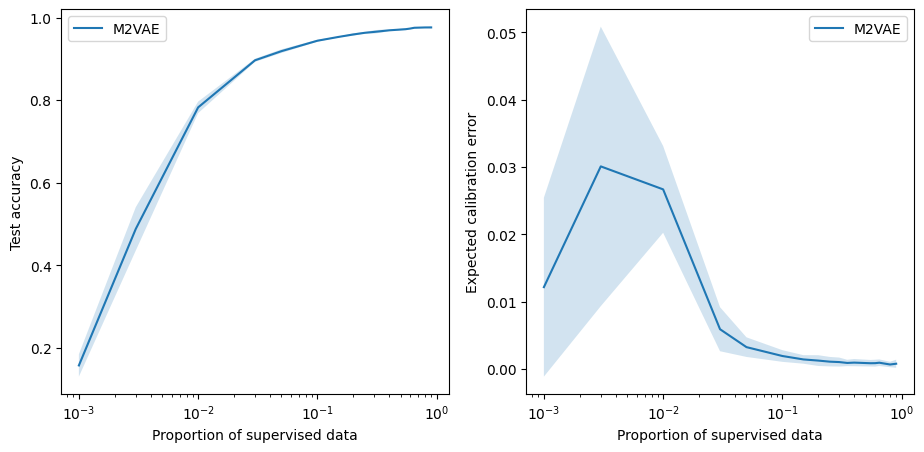

In [9]:
## Plotting in log scale

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(proportion_list, mean_test_accs, label="M2VAE")
plt.fill_between(proportion_list, mean_test_accs - std_test_accs*1.96/jnp.sqrt(num_ok), mean_test_accs + std_test_accs*1.96/jnp.sqrt(num_ok), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Test accuracy")
plt.xscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(proportion_list, mean_expected_calibration_error, label="M2VAE")
plt.fill_between(proportion_list, mean_expected_calibration_error - std_expected_calibration_error*1.96/jnp.sqrt(num_ok), mean_expected_calibration_error + std_expected_calibration_error*1.96/jnp.sqrt(num_ok), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Expected calibration error")
plt.xscale("log")
plt.legend()

## Analysing CCVAE results

In [10]:
test_accuracies_ccvae = jnp.zeros((len(seed_list), len(proportion_list)))

sum_probs_ccvae = jnp.zeros((len(seed_list), len(proportion_list), 10))

sum_accs_ccvae = jnp.zeros((len(seed_list), len(proportion_list), 10))

In [20]:
for seed in seed_list:
    for prop in proportion_list:
        img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.1, 
                                          p_val=0.1, 
                                          p_supervised=prop, 
                                          batch_size=200, 
                                          num_workers=6, 
                                          seed=seed)
        distribution = "bernouilli"
        scale_factor = 1.0

        m2_vae = CCVAE(encoder_class, 
                        decoder_class, 
                        10, 
                        50, 
                        img_shape, 
                        distribution=distribution
            )
        try:
            with open("./model_weights/ccvae_" + dataset_name + "_p_supervised_"+str(prop)+"_seed_"+str(seed)+".pkl", "rb") as file:
                params=pickle.load(file)

            test_loader = loader_dict['test']
            test_accuracy = 0.0
            num_test = 0

            for batch in test_loader:
                x, y = batch
                ypred, y_prob = m2_vae.classify(params, x, return_prob=True)
                if jnp.isnan(y_prob).any():
                    test_accuracy = -1
                    num_test = 1
                    break
                test_accuracy += jnp.sum(ypred == y)
                num_test += len(y)
                for i in range(10):
                    sum_probs_ccvae = sum_probs_ccvae.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(y_prob[y==i, i]))
                    sum_accs_ccvae = sum_accs_ccvae.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(ypred[y==i] == i))
            test_accuracy /= num_test
            test_accuracies_ccvae = test_accuracies_ccvae.at[seed_list.index(seed), proportion_list.index(prop)].set(test_accuracy)
        except FileNotFoundError:
            test_accuracies_ccvae = test_accuracies_ccvae.at[seed_list.index(seed), proportion_list.index(prop)].set(-1)
        

Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 48
Num unsupervised samples: 48552
Beta factor:  1.0
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 145
Num unsupervised samples: 48455
Beta factor:  1.0


KeyboardInterrupt: 

In [12]:
## Occasionnaly, some model have diverged and their output is NaN. We remove these models.

mean_test_accs_ccvae = jnp.zeros((len(proportion_list)))
std_test_accs_ccvae = jnp.zeros((len(proportion_list)))
num_ok_ccvae = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    mean_test_accs_ccvae = mean_test_accs_ccvae.at[i].set(jnp.mean(test_accuracies_ccvae[:, i][test_accuracies_ccvae[:, i] != -1]))
    std_test_accs_ccvae = std_test_accs_ccvae.at[i].set(jnp.std(test_accuracies_ccvae[:, i][test_accuracies_ccvae[:, i] != -1]))
    num_ok_ccvae = num_ok_ccvae.at[i].set(jnp.sum(test_accuracies_ccvae[:, i] != -1))

mean_expected_calibration_error_ccvae = jnp.zeros((len(proportion_list)))
std_expected_calibration_error_ccvae = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    ## Remove diverged models
    sum_probs_ok = sum_probs_ccvae[:, i][test_accuracies_ccvae[:, i] != -1]
    sum_accs_ok = sum_accs_ccvae[:, i][test_accuracies_ccvae[:, i] != -1]
    ## Compute expected calibration error
    mean_expected_calibration_error_ccvae = mean_expected_calibration_error_ccvae.at[i].set(jnp.mean(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)
    std_expected_calibration_error_ccvae = std_expected_calibration_error_ccvae.at[i].set(jnp.std(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)

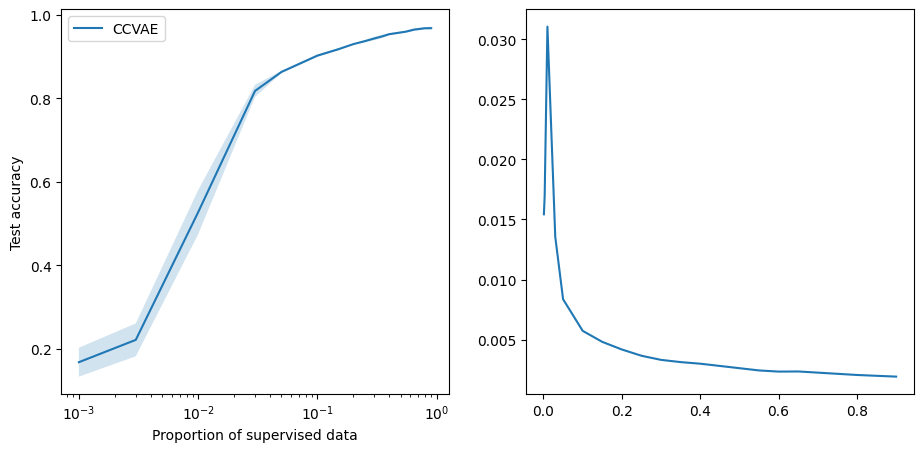

In [13]:
## Plotting in log scale

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(proportion_list, mean_test_accs_ccvae, label="CCVAE")
plt.fill_between(proportion_list, mean_test_accs_ccvae - std_test_accs_ccvae*1.96/jnp.sqrt(num_ok_ccvae), mean_test_accs_ccvae + std_test_accs_ccvae*1.96/jnp.sqrt(num_ok_ccvae), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Test accuracy")
plt.xscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(proportion_list, mean_expected_calibration_error_ccvae, label="CCVAE")



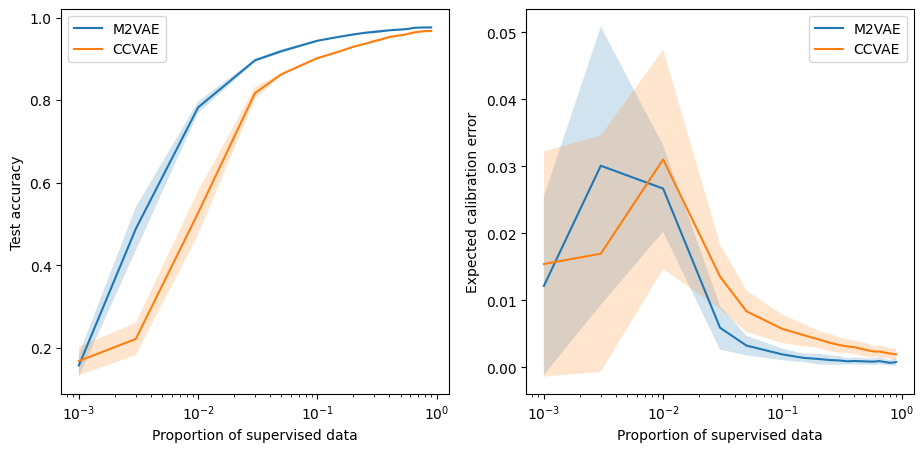

In [15]:
## Plot M2VAE and CCVAE on the same plot

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(proportion_list, mean_test_accs, label="M2VAE")
plt.fill_between(proportion_list, mean_test_accs - std_test_accs*1.96/jnp.sqrt(num_ok), mean_test_accs + std_test_accs*1.96/jnp.sqrt(num_ok), alpha=0.2)
plt.plot(proportion_list, mean_test_accs_ccvae, label="CCVAE")
plt.fill_between(proportion_list, mean_test_accs_ccvae - std_test_accs_ccvae*1.96/jnp.sqrt(num_ok_ccvae), mean_test_accs_ccvae + std_test_accs_ccvae*1.96/jnp.sqrt(num_ok_ccvae), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Test accuracy")
plt.xscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(proportion_list, mean_expected_calibration_error, label="M2VAE")
plt.fill_between(proportion_list, mean_expected_calibration_error - std_expected_calibration_error*1.96/jnp.sqrt(num_ok), mean_expected_calibration_error + std_expected_calibration_error*1.96/jnp.sqrt(num_ok), alpha=0.2)
plt.plot(proportion_list, mean_expected_calibration_error_ccvae, label="CCVAE")
plt.fill_between(proportion_list, mean_expected_calibration_error_ccvae - std_expected_calibration_error_ccvae*1.96/jnp.sqrt(num_ok_ccvae), mean_expected_calibration_error_ccvae + std_expected_calibration_error_ccvae*1.96/jnp.sqrt(num_ok_ccvae), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Expected calibration error")
plt.xscale("log")

plt.legend()


## Analysing Simple Classifier results

In [16]:
test_accuracies_class = jnp.zeros((len(seed_list), len(proportion_list)))

sum_probs_class = jnp.zeros((len(seed_list), len(proportion_list), 10))

sum_accs_class = jnp.zeros((len(seed_list), len(proportion_list), 10))

In [24]:
for seed in seed_list:
    for prop in proportion_list:
        img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.1, 
                                          p_val=0.1, 
                                          p_supervised=prop, 
                                          batch_size=200, 
                                          num_workers=6, 
                                          seed=seed)
        distribution = "bernouilli"
        scale_factor = 1.0

        classifier = SimpleClassifier(encoder_class, 
                        10)
        try:
            with open("./model_weights/classifier_" + dataset_name + "_p_supervised_"+str(prop)+"_seed_"+str(seed)+".pkl", "rb") as file:
                params=pickle.load(file)

            test_loader = loader_dict['test']
            test_accuracy = 0.0
            num_test = 0

            for batch in test_loader:
                x, y = batch
                logits = classifier.apply({'params': params}, x)
                ypred = jnp.argmax(logits, axis=1)
                y_prob = jax.nn.softmax(logits)
                if jnp.isnan(y_prob).any():
                    test_accuracy = -1
                    num_test = 1
                    break
                test_accuracy += jnp.sum(ypred == y)
                num_test += len(y)
                for i in range(10):
                    sum_probs_class = sum_probs_class.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(y_prob[y==i, i]))
                    sum_accs_class = sum_accs_class.at[seed_list.index(seed), proportion_list.index(prop), i].add(jnp.sum(ypred[y==i] == i))
            test_accuracy /= num_test
            test_accuracies_class = test_accuracies_class.at[seed_list.index(seed), proportion_list.index(prop)].set(test_accuracy)
        except FileNotFoundError:
            test_accuracies_class = test_accuracies_class.at[seed_list.index(seed), proportion_list.index(prop)].set(-1)


Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 48
Num unsupervised samples: 48552


Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 145
Num unsupervised samples: 48455
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 486
Num unsupervised samples: 48114
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 1458
Num unsupervised samples: 47142
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 2430
Num unsupervised samples: 46170
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 4860
Num unsupervised samples: 43740
Successfully loaded MNIST dataset.
Total num samples 60000
Num test samples: 6000
Num validation samples: 5400
Num supervised samples: 7290
Nu

In [25]:
## Occasionnaly, some model have diverged and their output is NaN. We remove these models.

mean_test_accs_class = jnp.zeros((len(proportion_list)))
std_test_accs_class = jnp.zeros((len(proportion_list)))
num_ok_class = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    mean_test_accs_class = mean_test_accs_class.at[i].set(jnp.mean(test_accuracies_class[:, i][test_accuracies_class[:, i] != -1]))
    std_test_accs_class = std_test_accs_class.at[i].set(jnp.std(test_accuracies_class[:, i][test_accuracies_class[:, i] != -1]))
    num_ok_class = num_ok_class.at[i].set(jnp.sum(test_accuracies_class[:, i] != -1))

mean_expected_calibration_error_class = jnp.zeros((len(proportion_list)))
std_expected_calibration_error_class = jnp.zeros((len(proportion_list)))

for i in range(len(proportion_list)):
    ## Remove diverged models
    sum_probs_ok = sum_probs_class[:, i][test_accuracies_class[:, i] != -1]
    sum_accs_ok = sum_accs_class[:, i][test_accuracies_class[:, i] != -1]
    ## Compute expected calibration error
    mean_expected_calibration_error_class = mean_expected_calibration_error_class.at[i].set(jnp.mean(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)
    std_expected_calibration_error_class = std_expected_calibration_error_class.at[i].set(jnp.std(jnp.abs(sum_probs_ok - sum_accs_ok))/num_test)

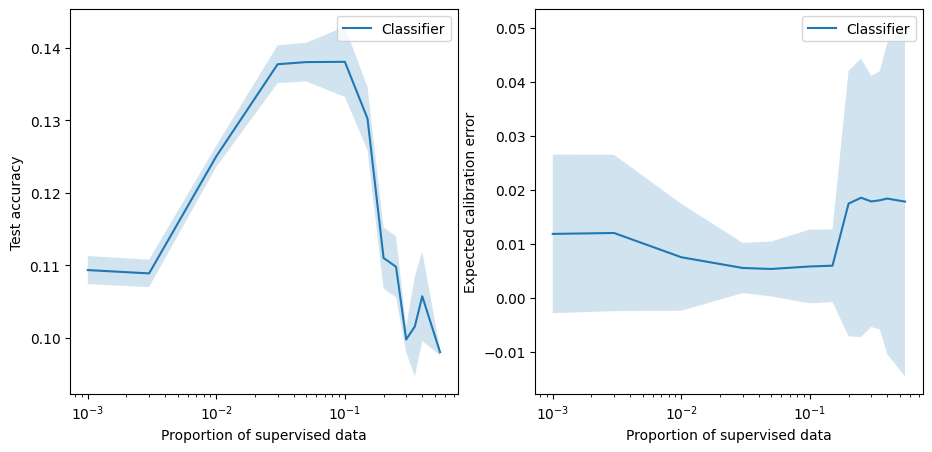

In [26]:
## Plotting in log scale

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(proportion_list, mean_test_accs_class, label="Classifier")
plt.fill_between(proportion_list, mean_test_accs_class - std_test_accs_class*1.96/jnp.sqrt(num_ok_class), mean_test_accs_class + std_test_accs_class*1.96/jnp.sqrt(num_ok_class), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Test accuracy")

plt.xscale("log")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(proportion_list, mean_expected_calibration_error_class, label="Classifier")
plt.fill_between(proportion_list, mean_expected_calibration_error_class - std_expected_calibration_error_class*1.96/jnp.sqrt(num_ok_class), mean_expected_calibration_error_class + std_expected_calibration_error_class*1.96/jnp.sqrt(num_ok_class), alpha=0.2)
plt.xlabel("Proportion of supervised data")
plt.ylabel("Expected calibration error")
plt.xscale("log")

plt.legend()